In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
# sys.path.append(os.getcwd()+'/../adjust/rasotools/')
# from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
import copy
import pickle
import xarray as xr

import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
sys.path.append(os.getcwd()+'/../')
import metutils as mu
import trajectory as trj
 

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Calculate the trajectory RMSE

In [3]:
def trajectory_rmse (stats, year, month=False, time=False, show_ascents=False, show_date=False, min_disp=0, compare_to='fc', diff=False):
    print('compare to: ', compare_to)
    maxtimediff = pd.Timedelta(hours=2)
    for stat in stats:
        statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
        df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
        # 2020 only
        df = df[df.date_time.dt.year == year]
        # night only -> ~ 00:00
        if time:
            df = df[np.isin(df.date_time.dt.hour,time)]
            
        # stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
        stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
        rmse_sum_shbase_sonde={}
        rmse_sum_shbase_adjsonde={}
        rmse_sum_shdisp_sonde={}
        rmse_sum_shdisp_adjsonde={}
        rms_sum_shbase={}
        rms_sum_adjsonde={}
        rms_sum_sonde={}
        rms_sum_shdisp={}
        rms_sum_dispminusbase={}

        for i in stdplevs:
            rmse_sum_shbase_sonde[i] = []
            rmse_sum_shbase_adjsonde[i] = []
            rmse_sum_shdisp_sonde[i] = []
            rmse_sum_shdisp_adjsonde[i] = []
            rms_sum_shbase[i] = []
            rms_sum_adjsonde[i] = []
            rms_sum_sonde[i] = []
            rms_sum_shdisp[i] = []
            rms_sum_dispminusbase[i] = []
        
        if month == False:
            month = [1,2,3,4,5,6,7,8,9,10,11,12]
        else:
            month = [month]
        for m in month:
            if compare_to == 'fc':
                files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(year)+str(m).zfill(2)+'*.131.nc')[0]
            else:
                files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t.'+str(year)+str(m).zfill(2)+'*.131.nc')[0]
            ds_fc = xr.load_dataset(files)
            
            df_mon = df[df.date_time.dt.month == m]
            
            for day in df_mon.date_time.drop_duplicates()[:]:
                try:
                    test = df_mon[df_mon.date_time == day]
                    if show_date:
                        print(day)

                    ds_fc_time = ds_fc.sel(time=day, method='nearest')
                    if (pd.Timestamp(ds_fc_time.time.values) - day) > maxtimediff:
                        continue

                    t = test[test.observed_variable == 85]
                    t = t.rename(columns={'observation_value':'temperature'})
                    t = t.drop(columns='observed_variable')

                    q = test[test.observed_variable == 38]
                    q = q.rename(columns={'observation_value':'rh'})
                    q = q.drop(columns='observed_variable')

                    u = test[test.observed_variable == 104]
                    u = u.rename(columns={'observation_value':'u'})
                    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

                    v = test[test.observed_variable == 105]
                    v = v.rename(columns={'observation_value':'v'})
                    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

                    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
                    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
                    input_data = pd.merge(input_data, q, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

                    input_data = input_data.dropna()
                    input_data = input_data.reindex(index=input_data.index[::-1])
                    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))
                    if (np.abs(np.nanmax(phys_model[0])) < min_disp) and (np.abs(np.nanmax(phys_model[1])) < min_disp):
        #                 print(np.nanmax(phys_model[0]), np.nanmax(phys_model[1]))
                        continue
                    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
                    input_data['calc_latd'] = np.array(phys_model[0])
                    input_data['calc_lond'] = np.array(phys_model[1])
                    input_data = input_data.reindex(index=input_data.index[::-1])
                    input_data = input_data.reset_index()

        #                 display(ds_fc_time)
                #     ds_fc_loc = ds_fc_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
                #     df_fc_loc = ds_fc_loc.to_dataframe()

                #     display(input_data)
                    t_list = []
                    for i in np.array(ds_fc_time.level): #10,20,...,1000
                        step = find_nearest(input_data.z_coordinate, i*100)
                #         print('step - level: ', step)
                        input_data_step = input_data[input_data.z_coordinate == step]
                #         print('displacement: ', input_data_step.calc_latd)
                        station_lat = input_data.latitude[0] + np.array(input_data_step.calc_latd)[0]
                #         print(i, input_data.latitude[0], station_lat)
                        station_lon = input_data.longitude[0] + np.array(input_data_step.calc_lond)[0]
                #         print(i, input_data.longitude[0], station_lon)
                        lon = station_lon
                        if lon < 0:
                            lon = 360.+lon
                        ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
                #         print('selected lat: ', float(ds_now.latitude))
                        t = ds_now.u.sel(level = i)
                        t_list.append(float(t))

                #     print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
                #     print(stat)
                #     print(day)
                    p_ml = [  1000,   2000,   3000,   5000,   7000,  10000,  15000,  20000,  25000,  30000,  40000,  50000,  70000,  85000,  92500, 100000]
                    lon = input_data.longitude[0]
                    if lon < 0:
                        lon = 360.+lon
                    base_t = np.array(ds_fc_time.interp(latitude=[input_data.latitude[0]], longitude=[lon], method="linear").u)
                    for i in range(len(stdplevs)):
                        if np.abs(stdplevs[i] - find_nearest(input_data.z_coordinate,stdplevs[i])) > 500:
    #                             print(stdplevs[i] , find_nearest(p_ml,stdplevs[i]))
                            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
                            rms_sum_shbase[stdplevs[i]].append(np.nan)
                            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
                            rms_sum_sonde[stdplevs[i]].append(np.nan)
                            rms_sum_shdisp[stdplevs[i]].append(np.nan)
                            rms_sum_dispminusbase[stdplevs[i]].append(np.nan)

                        else:
                            sq_t = np.squeeze(base_t)

                            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
                            t_sonde = float(input_data_step.u)
                #             t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
                            t_adjsonde = float(input_data_step.u)# - float(input_data_step['an_depar@body'])

                            t_base = float(sq_t[p_ml == find_nearest(p_ml,stdplevs[i])])
    #                             t_base = mu.spHumToRH(t_base, float(input_data_step.temperature)-273.15, stdplevs[i]/1000.)/10.
                            t_disp = float(np.array(t_list)[p_ml == find_nearest(p_ml,stdplevs[i])])
    #                             t_disp = mu.spHumToRH(t_disp, float(input_data_step.temperature)-273.15, stdplevs[i]/1000.)/10.


                            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
                            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
                            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
                            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
                            rms_sum_shbase[stdplevs[i]].append(t_base)
                            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
                            rms_sum_sonde[stdplevs[i]].append(t_sonde)
                            rms_sum_shdisp[stdplevs[i]].append(t_disp)
                            rms_sum_dispminusbase[stdplevs[i]].append(t_disp-t_base)


                    if show_ascents:
                        fig, ax1 = maplt.subplots(1, figsize=(16, 8))
                        ax1.plot(np.squeeze(base_t), np.array(p_ml), color = 'green', alpha = 0.6, label='base u')
                        ax1.plot(np.array(t_list), np.array(p_ml), color = 'blue', alpha = 0.2,ls = '--', label='displaced u')
                        plt_sonde_t = []
                        for pl in stdplevs:
                            apl = find_nearest(input_data.z_coordinate, pl)
                            plt_sonde_t.append(float(input_data[input_data.z_coordinate == apl].u))
                        ax1.plot(np.array(plt_sonde_t), np.array(stdplevs), color = 'red', alpha = 0.2,ls = '--', label='u radio sonde')
    #                         ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.2,ls = '--', label='temperature radio sonde')
                    #     ax1.plot(np.array(input_data.temperature - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - an_depar')
                        ax1.set_ylabel('pressure (Pa)')
                        ax1.set_xlabel('u [m/s]')
                        ax1.tick_params(axis='y')
                        ax1.set_ylim(ax1.get_ylim()[::-1])
                        ax1.legend()
                        ax1.grid()
                        maplt.show()
                        maplt.close()
                except:
                    pass
            
        print('valid ascents: ', len(rms_sum_shdisp[50000]))

        rmse_shbase_sonde=[]
        rmse_shbase_adjsonde=[]
        rmse_shdisp_sonde=[]
        rmse_shdisp_adjsonde=[]

        rms_shbase=[]
        rms_adjsonde=[]
        rms_sonde=[]
        rms_shdisp=[]
        rms_dispmbase=[]

        for i in range(len(stdplevs)):
            rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
            rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
            rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
            rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

            rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
            if show_date:    
                print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
            rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
            rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
            rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
            if show_date:
                print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])
            rms_dispmbase.append(np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]])**2))))
            if show_date:
                print('rms_dispmbase - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])


        print('')

        fig, ax1 = maplt.subplots(figsize = (15,10))
        ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='rmse_base_sonde')
        ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='rmse_disp_sonde')
#         ax1.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='diff')
#         ax1.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')
        
        ax1_4 = ax1.twiny()
        ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
        if diff:
            ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='diff')
        ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')

#         ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
#         ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
        ax1_4.legend(loc='lower left')
        ax1.set_ylim(ax1.get_ylim()[::-1])
        ax1.set_ylabel('pressure (Pa)')
        ax1.set_xlabel('u RMSE [m/s]')
        ax1.legend(loc='upper right')
        ax1.grid()

        maplt.title(str(stat)+' LEVEL u wind RMSE')
        maplt.show()
        maplt.close()
        
        from scipy.signal import savgol_filter
        # stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
        stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]
        rmse_sum_shbase_sonde={}
        rmse_sum_shbase_adjsonde={}
        rmse_sum_shdisp_sonde={}
        rmse_sum_shdisp_adjsonde={}
        rms_sum_shbase={}
        rms_sum_adjsonde={}
        rms_sum_sonde={}
        rms_sum_shdisp={}
        rms_sum_dispminusbase={}

        for i in stdplevs:
            rmse_sum_shbase_sonde[i] = []
            rmse_sum_shbase_adjsonde[i] = []
            rmse_sum_shdisp_sonde[i] = []
            rmse_sum_shdisp_adjsonde[i] = []
            rms_sum_shbase[i] = []
            rms_sum_adjsonde[i] = []
            rms_sum_sonde[i] = []
            rms_sum_shdisp[i] = []
            rms_sum_dispminusbase[i] = []
          
        
        for m in month:
            if compare_to == 'fc':
                files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.'+str(year)+str(m).zfill(2)+'*.132.nc')[0]
            else:
                files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5t.'+str(year)+str(m).zfill(2)+'*.132.nc')[0]
            ds_fc = xr.load_dataset(files)
            
            df_mon = df[df.date_time.dt.month == m]
            
            for day in df_mon.date_time.drop_duplicates()[:]:
                try:
                    test = df_mon[df_mon.date_time == day]
                    if show_date:
                        print(day)

                    ds_fc_time = ds_fc.sel(time=day, method='nearest')
                    if (pd.Timestamp(ds_fc_time.time.values) - day) > maxtimediff:
                        continue

                    t = test[test.observed_variable == 85]
                    t = t.rename(columns={'observation_value':'temperature'})
                    t = t.drop(columns='observed_variable')

                    q = test[test.observed_variable == 38]
                    q = q.rename(columns={'observation_value':'rh'})
                    q = q.drop(columns='observed_variable')

                    u = test[test.observed_variable == 104]
                    u = u.rename(columns={'observation_value':'u'})
                    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

                    v = test[test.observed_variable == 105]
                    v = v.rename(columns={'observation_value':'v'})
                    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

                    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
                    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
                    input_data = pd.merge(input_data, q, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

                    input_data = input_data.dropna()
                    input_data = input_data.reindex(index=input_data.index[::-1])
                    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))
                    if (np.abs(np.nanmax(phys_model[0])) < min_disp) and (np.abs(np.nanmax(phys_model[1])) < min_disp):
        #                 print(np.nanmax(phys_model[0]), np.nanmax(phys_model[1]))
                        continue
                    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
                    input_data['calc_latd'] = np.array(phys_model[0])
                    input_data['calc_lond'] = np.array(phys_model[1])
                    input_data = input_data.reindex(index=input_data.index[::-1])
                    input_data = input_data.reset_index()

        #                 display(ds_fc_time)
                #     ds_fc_loc = ds_fc_time.interp(latitude=search_lat, longitude=search_lon, method='linear')
                #     df_fc_loc = ds_fc_loc.to_dataframe()

                #     display(input_data)
                    t_list = []
                    for i in np.array(ds_fc_time.level): #10,20,...,1000
                        step = find_nearest(input_data.z_coordinate, i*100)
                #         print('step - level: ', step)
                        input_data_step = input_data[input_data.z_coordinate == step]
                #         print('displacement: ', input_data_step.calc_latd)
                        station_lat = input_data.latitude[0] + np.array(input_data_step.calc_latd)[0]
                #         print(i, input_data.latitude[0], station_lat)
                        station_lon = input_data.longitude[0] + np.array(input_data_step.calc_lond)[0]
                #         print(i, input_data.longitude[0], station_lon)
                        lon = station_lon
                        if lon < 0:
                            lon = 360.+lon
                        ds_now = ds_fc_time.interp(latitude=[station_lat], longitude=[lon], method="linear")
                #         print('selected lat: ', float(ds_now.latitude))
                        t = ds_now.v.sel(level = i)
                        t_list.append(float(t))

                #     print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
                #     print(stat)
                #     print(day)
                    p_ml = [  1000,   2000,   3000,   5000,   7000,  10000,  15000,  20000,  25000,  30000,  40000,  50000,  70000,  85000,  92500, 100000]
                    lon = input_data.longitude[0]
                    if lon < 0:
                        lon = 360.+lon
                    base_t = np.array(ds_fc_time.interp(latitude=[input_data.latitude[0]], longitude=[lon], method="linear").v)
                    for i in range(len(stdplevs)):
                        if np.abs(stdplevs[i] - find_nearest(input_data.z_coordinate,stdplevs[i])) > 500:
    #                             print(stdplevs[i] , find_nearest(p_ml,stdplevs[i]))
                            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
                            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
                            rms_sum_shbase[stdplevs[i]].append(np.nan)
                            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
                            rms_sum_sonde[stdplevs[i]].append(np.nan)
                            rms_sum_shdisp[stdplevs[i]].append(np.nan)
                            rms_sum_dispminusbase[stdplevs[i]].append(np.nan)

                        else:
                            sq_t = np.squeeze(base_t)

                            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
                            t_sonde = float(input_data_step.v)
                #             t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
                            t_adjsonde = float(input_data_step.v)# - float(input_data_step['an_depar@body'])

                            t_base = float(sq_t[p_ml == find_nearest(p_ml,stdplevs[i])])
    #                             t_base = mu.spHumToRH(t_base, float(input_data_step.temperature)-273.15, stdplevs[i]/1000.)/10.
                            t_disp = float(np.array(t_list)[p_ml == find_nearest(p_ml,stdplevs[i])])
    #                             t_disp = mu.spHumToRH(t_disp, float(input_data_step.temperature)-273.15, stdplevs[i]/1000.)/10.


                            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
                            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
                            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
                            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
                            rms_sum_shbase[stdplevs[i]].append(t_base)
                            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
                            rms_sum_sonde[stdplevs[i]].append(t_sonde)
                            rms_sum_shdisp[stdplevs[i]].append(t_disp)
                            rms_sum_dispminusbase[stdplevs[i]].append(t_disp-t_base)


                    if show_ascents:
                        fig, ax1 = maplt.subplots(1, figsize=(16, 8))
                        ax1.plot(np.squeeze(base_t), np.array(p_ml), color = 'green', alpha = 0.6, label='base v')
                        ax1.plot(np.array(t_list), np.array(p_ml), color = 'blue', alpha = 0.2,ls = '--', label='displaced v')
                        plt_sonde_t = []
                        for pl in stdplevs:
                            apl = find_nearest(input_data.z_coordinate, pl)
                            plt_sonde_t.append(float(input_data[input_data.z_coordinate == apl].v))
                        ax1.plot(np.array(plt_sonde_t), np.array(stdplevs), color = 'red', alpha = 0.2,ls = '--', label='v radio sonde')
    #                         ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.2,ls = '--', label='temperature radio sonde')
                    #     ax1.plot(np.array(input_data.temperature - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - an_depar')
                        ax1.set_ylabel('pressure (Pa)')
                        ax1.set_xlabel('v [m/s]')
                        ax1.tick_params(axis='y')
                        ax1.set_ylim(ax1.get_ylim()[::-1])
                        ax1.legend()
                        ax1.grid()
                        maplt.show()
                        maplt.close()
                except:
                    pass
            
        print('valid ascents: ', len(rms_sum_shdisp[50000]))

        rmse_shbase_sonde=[]
        rmse_shbase_adjsonde=[]
        rmse_shdisp_sonde=[]
        rmse_shdisp_adjsonde=[]

        rms_shbase=[]
        rms_adjsonde=[]
        rms_sonde=[]
        rms_shdisp=[]
        rms_dispmbase=[]

        for i in range(len(stdplevs)):
            rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
            rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
            rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
            rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

            rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
            if show_date:    
                print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
            rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
            if show_date:    
                print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
            rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
            if show_date:    
                print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
            rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
            if show_date:
                print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])
            rms_dispmbase.append(np.sqrt(np.nanmean((np.array(rms_sum_dispminusbase[stdplevs[i]])**2))))
            if show_date:
                print('rms_dispmbase - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])


        print('')

        fig, ax1 = maplt.subplots(figsize = (15,10))
        ax1.plot(np.array(rmse_shbase_sonde),stdplevs,color='orange', label='rmse_base_sonde')
        ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, color='red', label='rmse_disp_sonde')
#         ax1.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='diff')
#         ax1.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')
        
        ax1_4 = ax1.twiny()
        ax1_4.axvline(x=0, color='black', alpha=0.8, ls='--', lw=0.5)
        if diff:
            ax1_4.plot(np.array(rmse_shbase_sonde)-np.array(rmse_shdisp_sonde),stdplevs,color='purple', label='diff')
        ax1_4.plot(np.array(rms_dispmbase),stdplevs, color='green', alpha=0.3, ls='--', label='rms_disp_minus_base')

#         ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
#         ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
        ax1_4.legend(loc='lower left')
        ax1.set_ylim(ax1.get_ylim()[::-1])
        ax1.set_ylabel('pressure (Pa)')
        ax1.set_xlabel('v RMSE [m/s]')
        ax1.legend(loc='upper right')
        ax1.grid()

        maplt.title(str(stat)+' LEVEL v wind RMSE')
        maplt.show()
        maplt.close()

compare to:  fc
valid ascents:  234



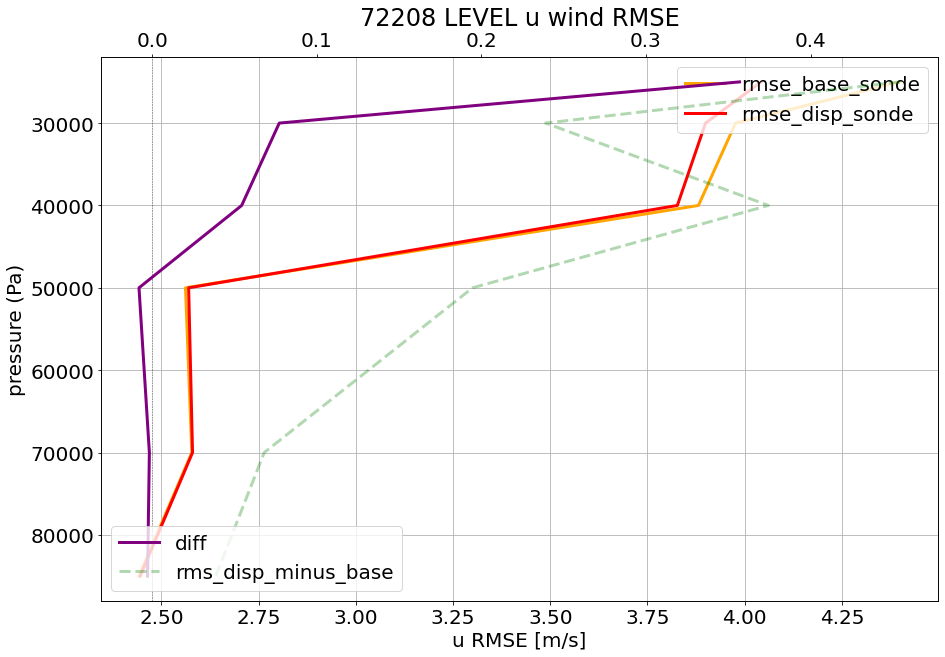

valid ascents:  234



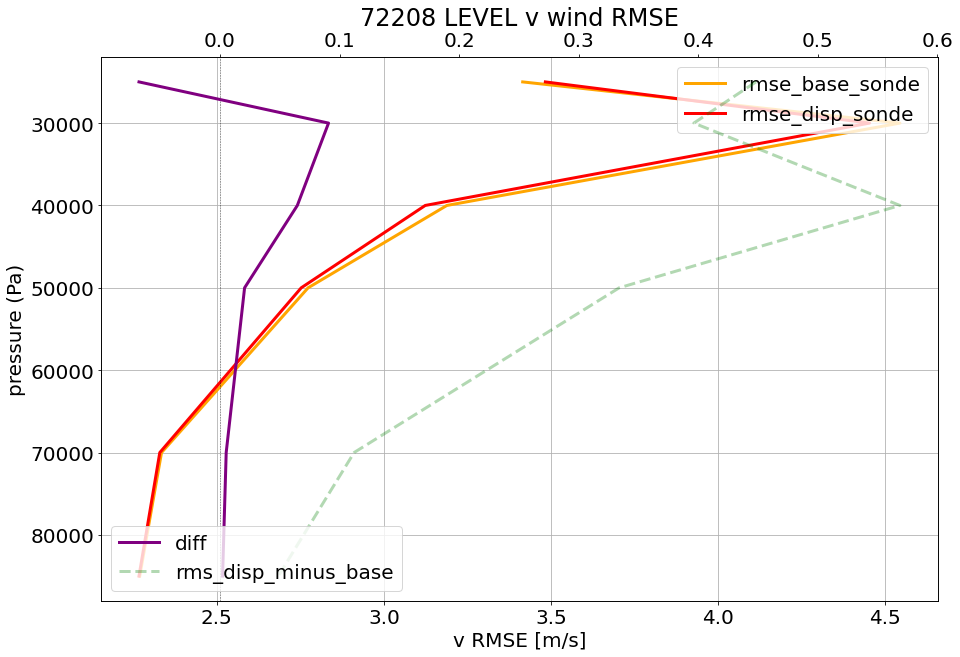

In [4]:
# east
stats = ['72208']
year = 1950
time = [15]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

compare to:  fc
valid ascents:  124



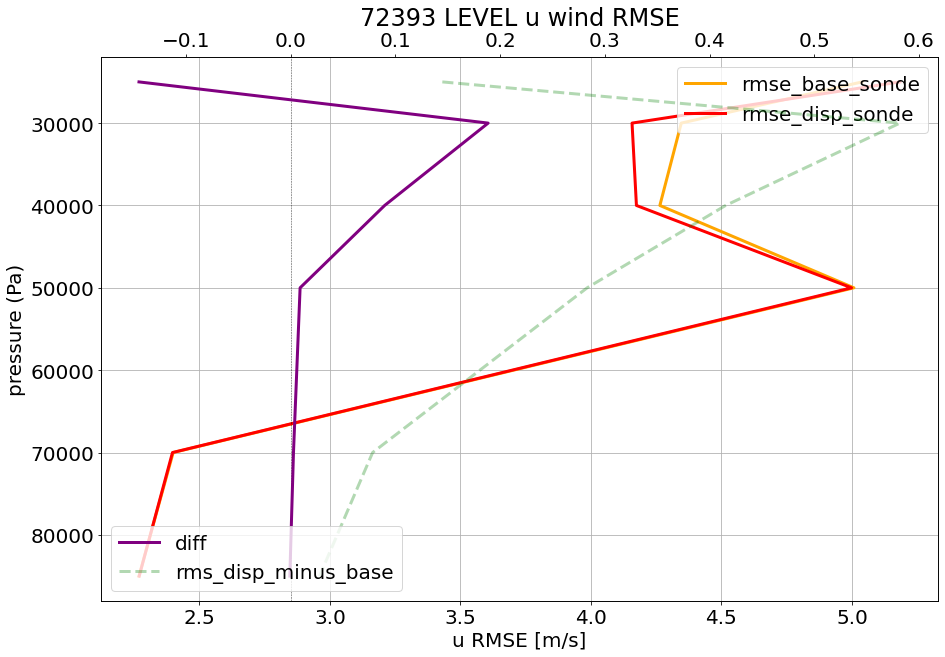

valid ascents:  124



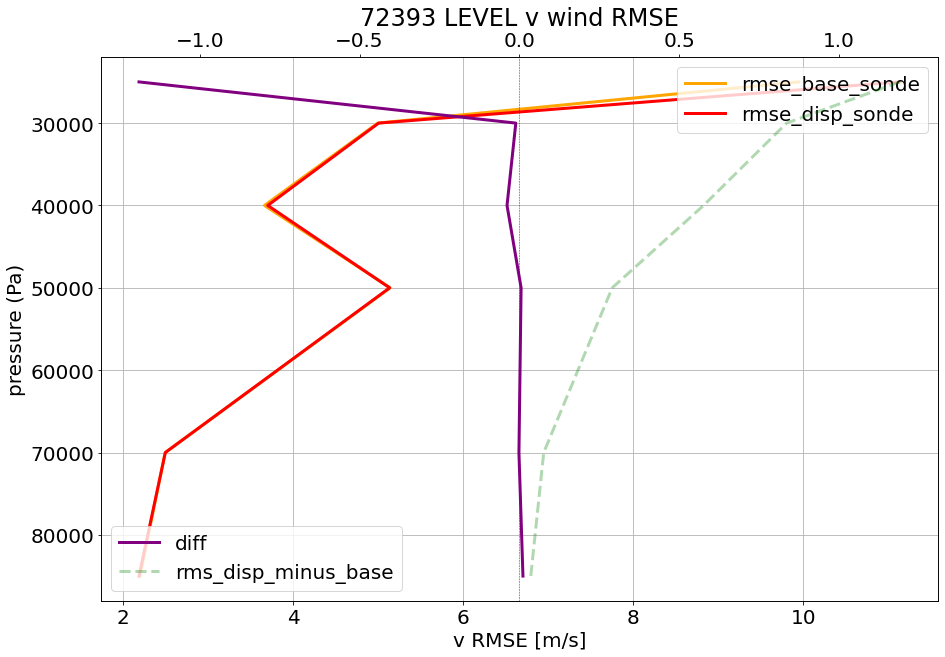

In [5]:
# west
stats = ['72393']
year = 1950
time = [15]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

compare to:  fc
valid ascents:  603



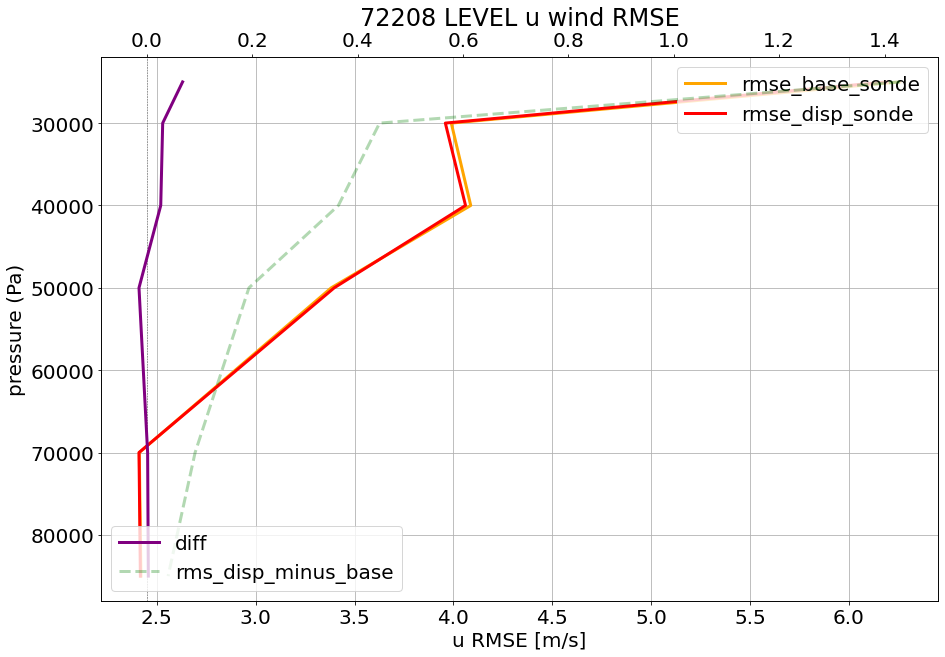

valid ascents:  603



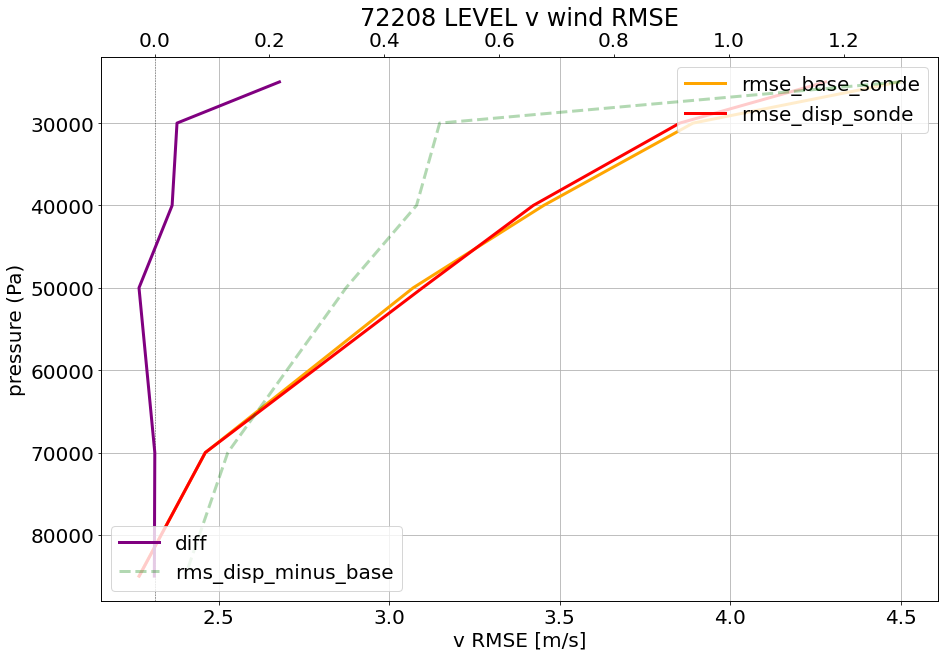

In [6]:
# east
stats = ['72208']
year = 1960
time = False
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

compare to:  fc
valid ascents:  916



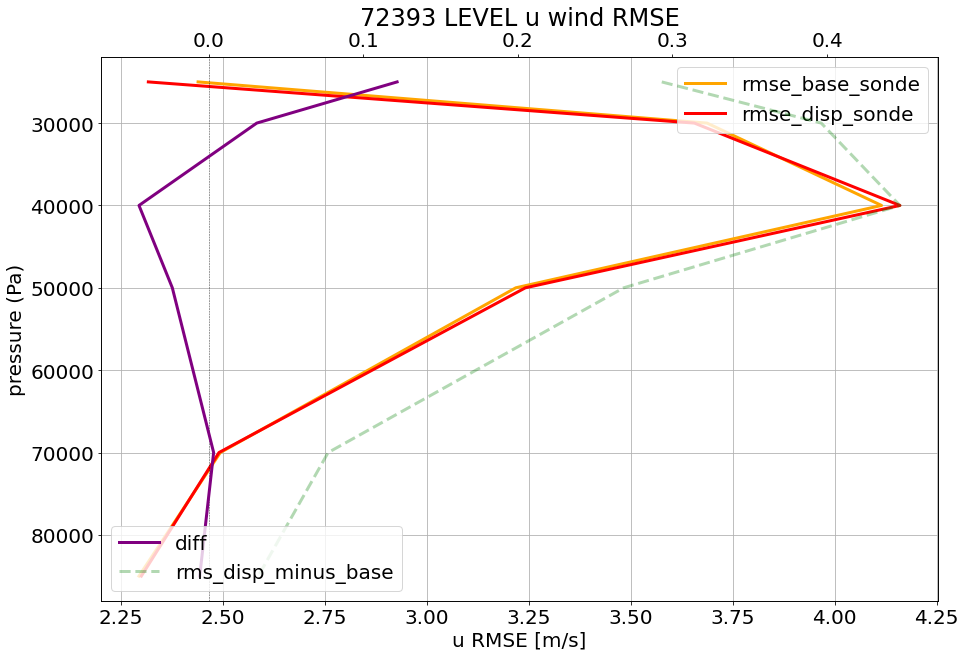

valid ascents:  916



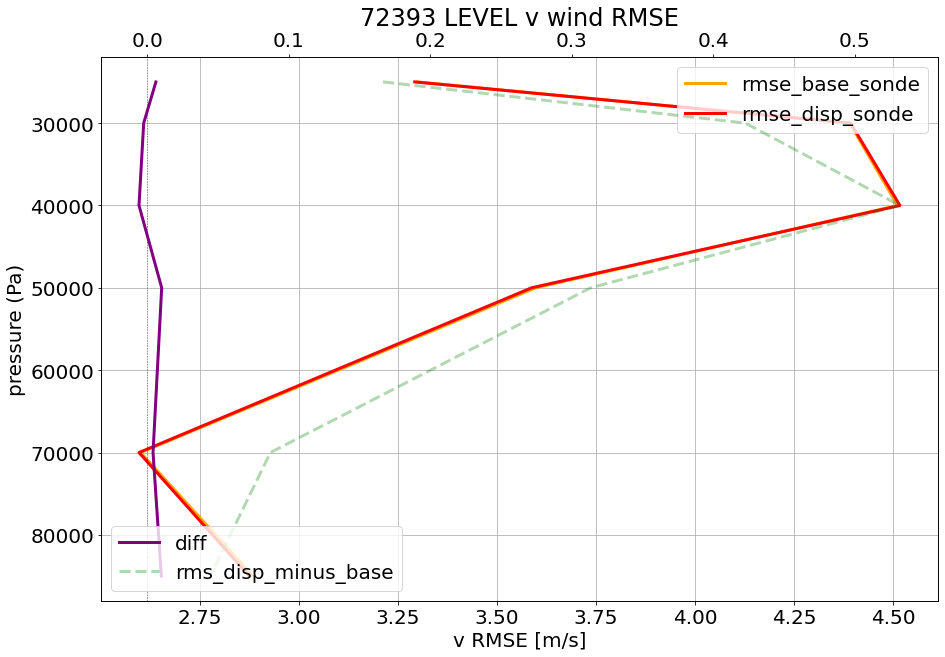

In [7]:
# west
stats = ['72393']
year = 1960
time = False
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc', diff=True)

# Forecast

compare to:  fc
valid ascents:  364



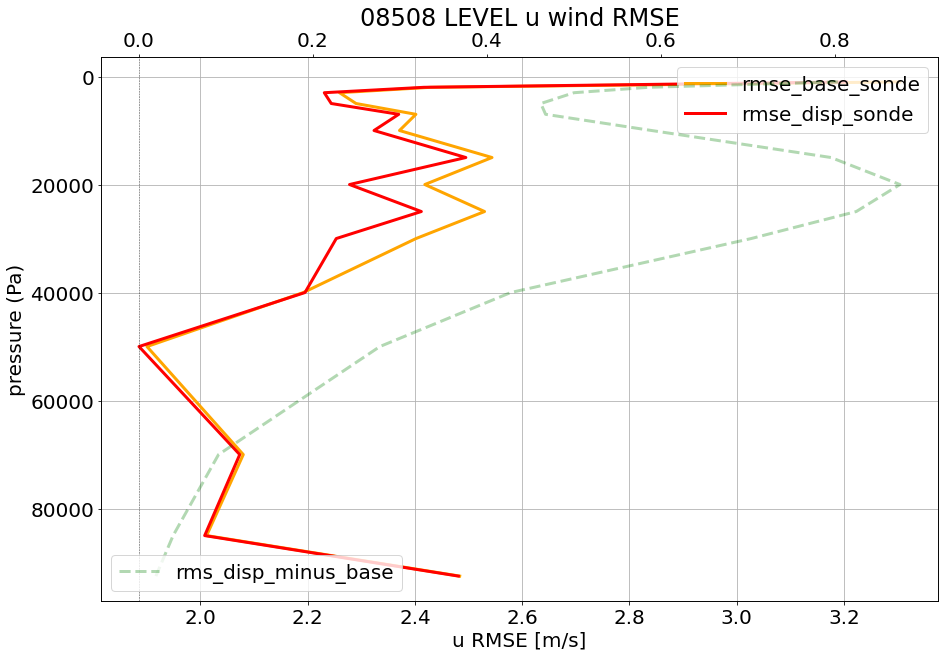

valid ascents:  364



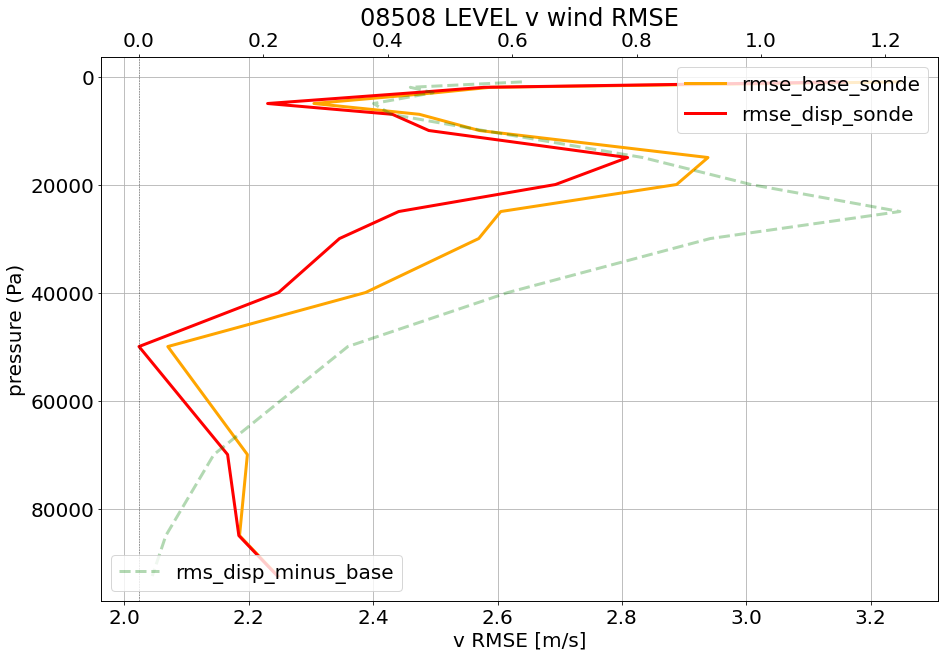

In [8]:
stats = ['08508']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')


compare to:  fc
valid ascents:  361



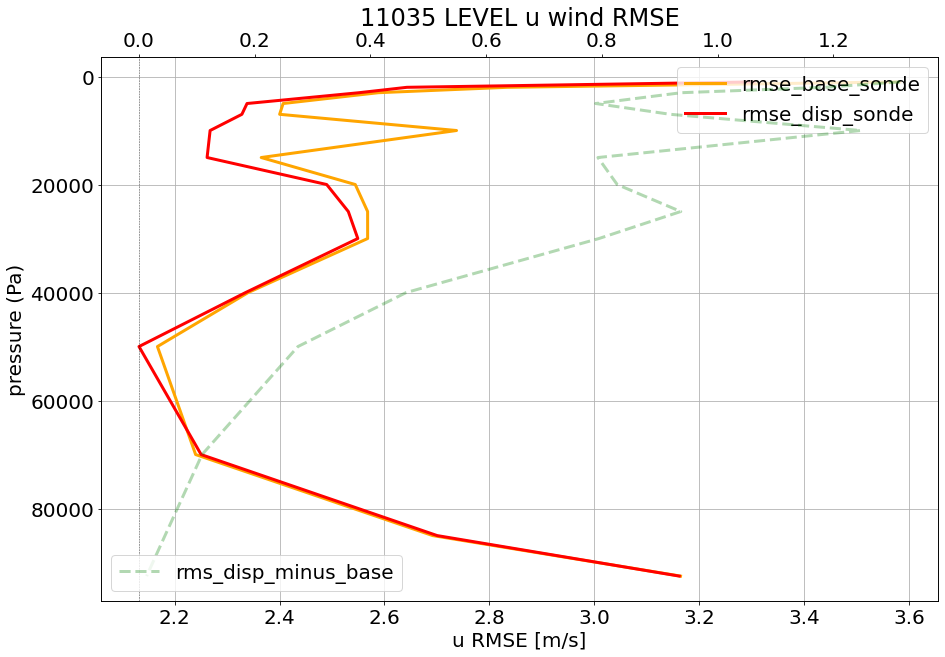

valid ascents:  361



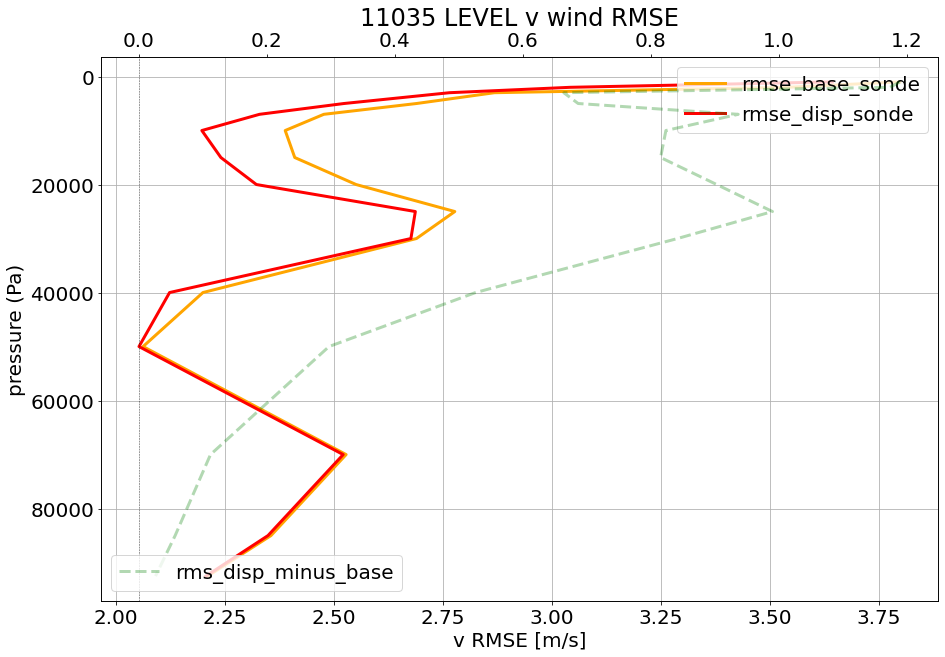

In [9]:
stats = ['11035']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

compare to:  fc
valid ascents:  362



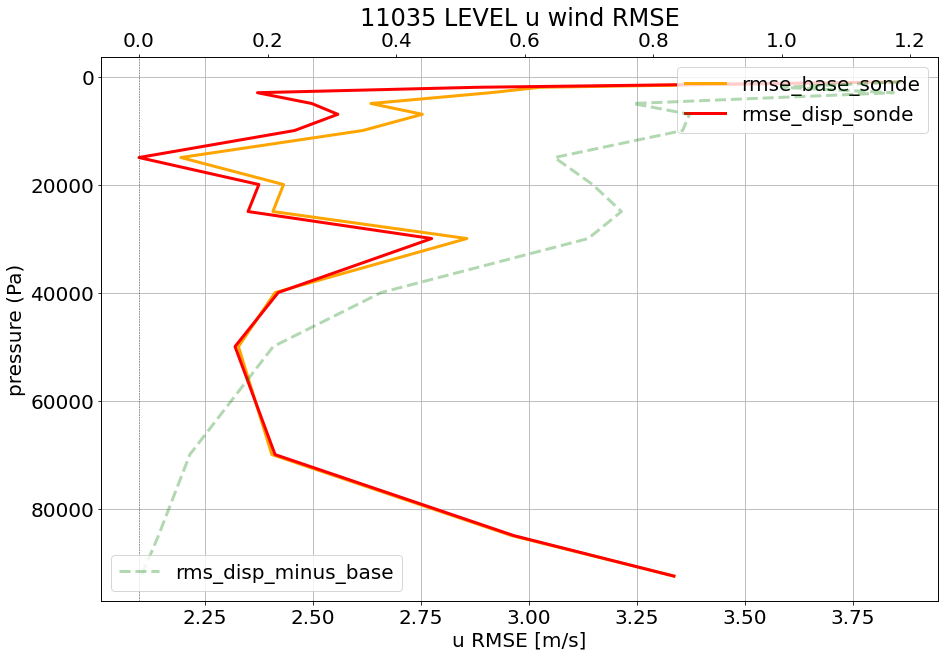

valid ascents:  362



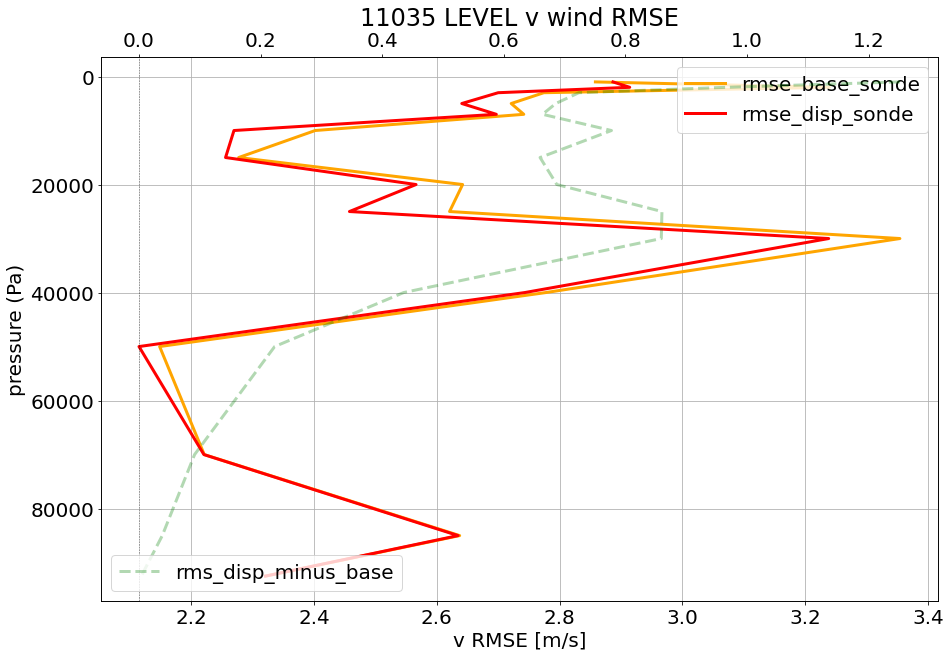

In [10]:
stats = ['11035']
year = 2010
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

In [ ]:
stats = ['70219']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

compare to:  fc
valid ascents:  348



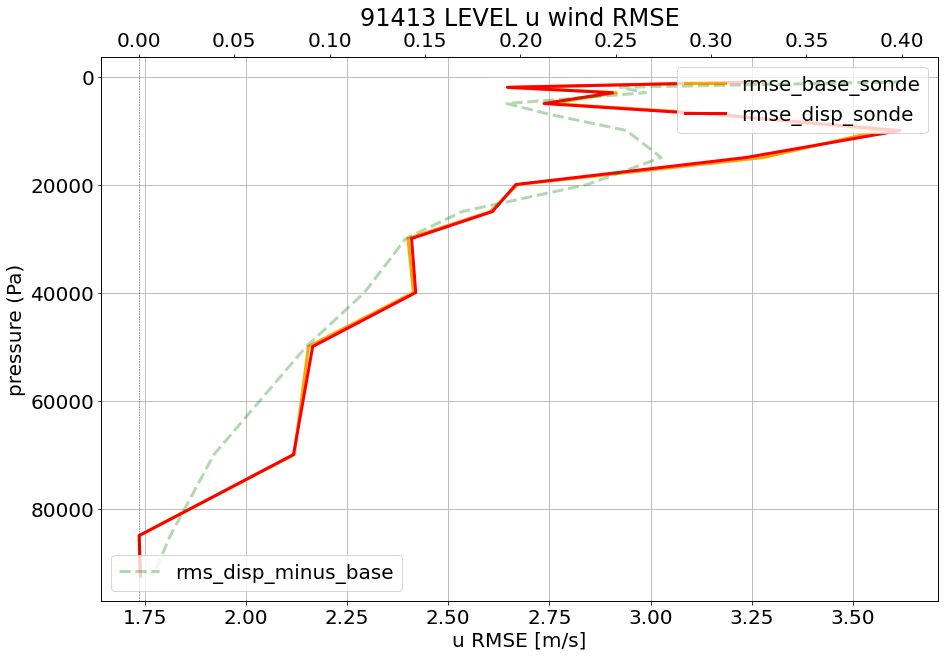

valid ascents:  348



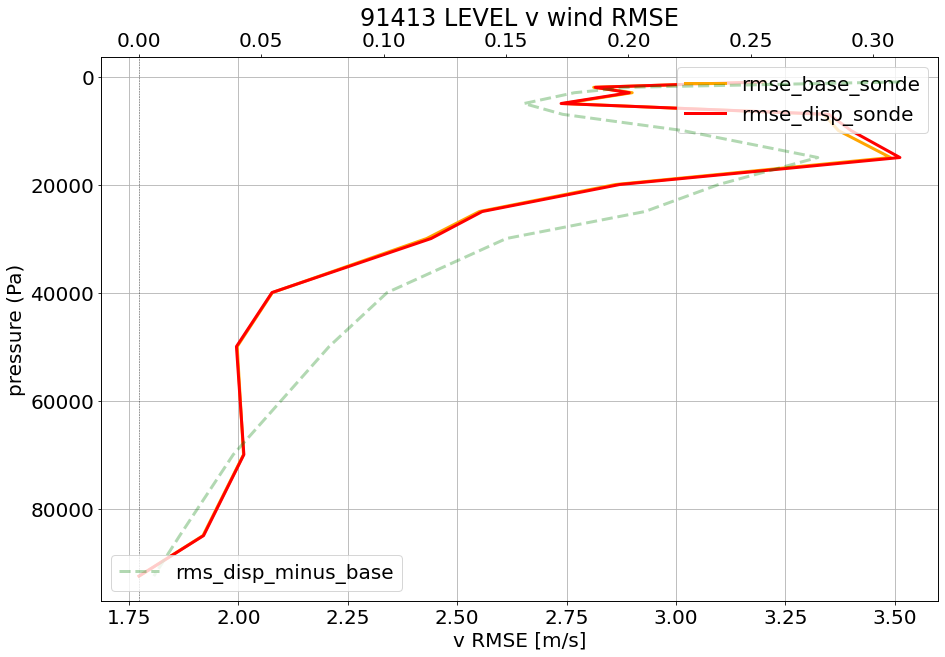

In [11]:
stats = ['91413']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

compare to:  fc
valid ascents:  366



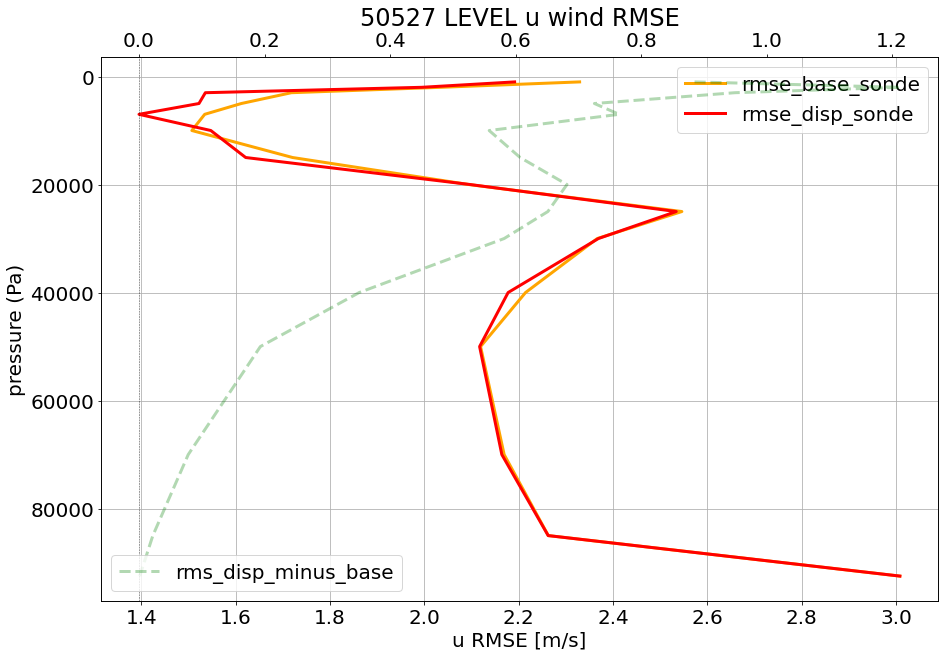

valid ascents:  366



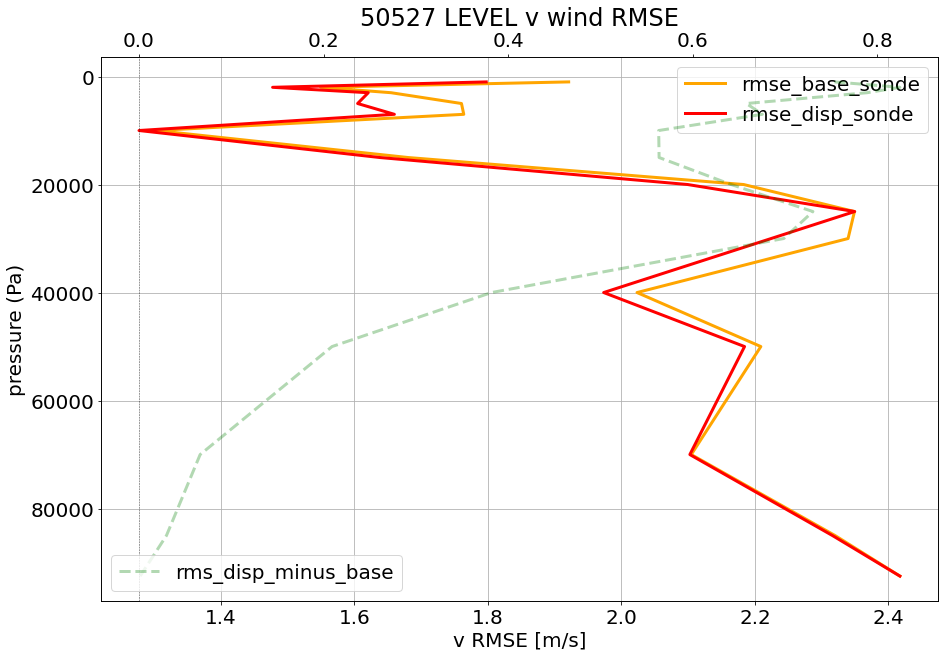

In [12]:
stats = ['50527']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

compare to:  fc
valid ascents:  351



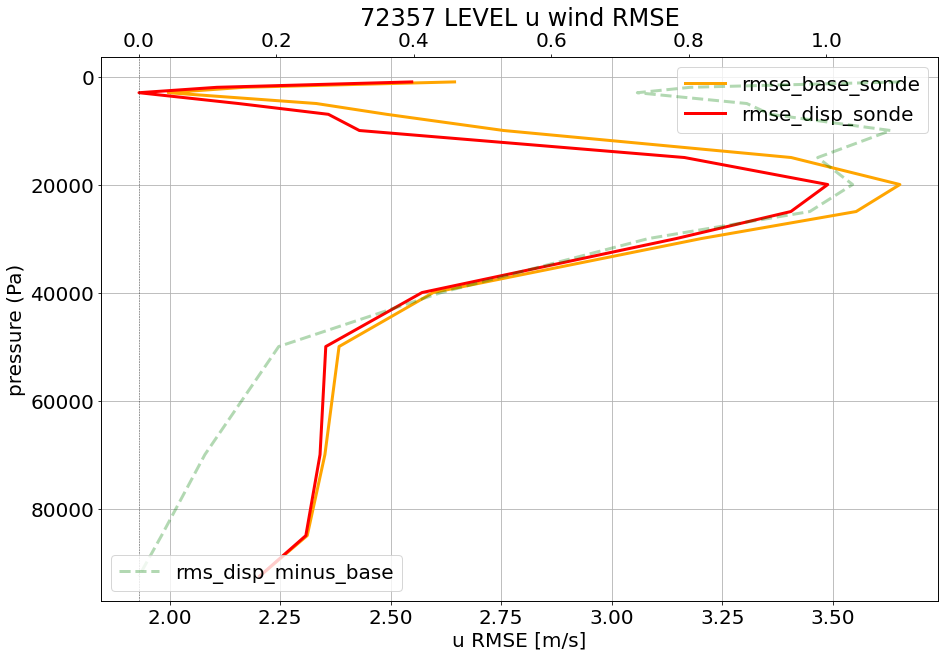

valid ascents:  351



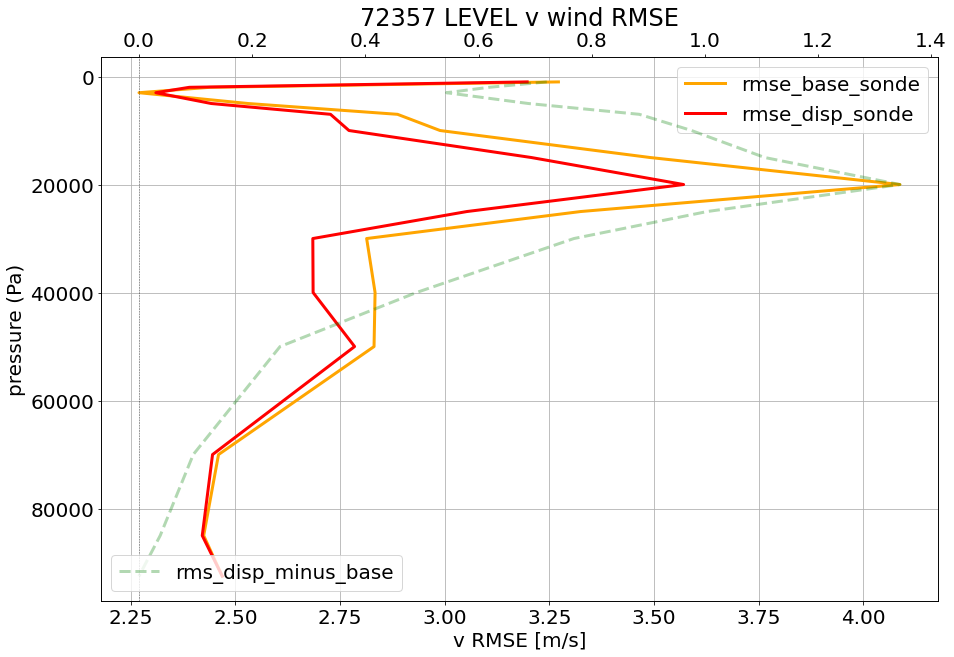

In [13]:
stats = ['72357']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')

# Analysis

compare to:  an
valid ascents:  364



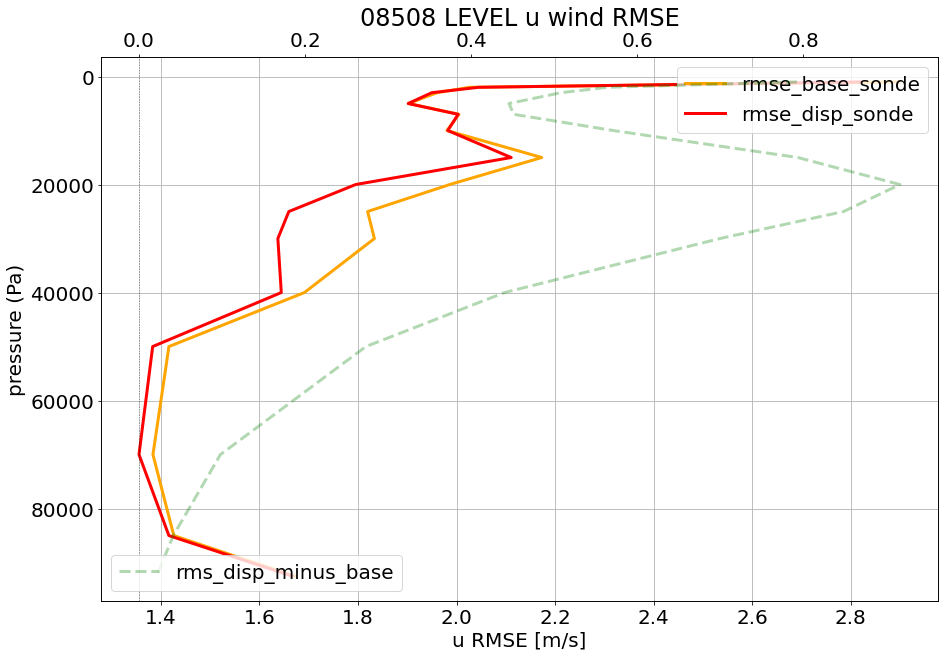

valid ascents:  364



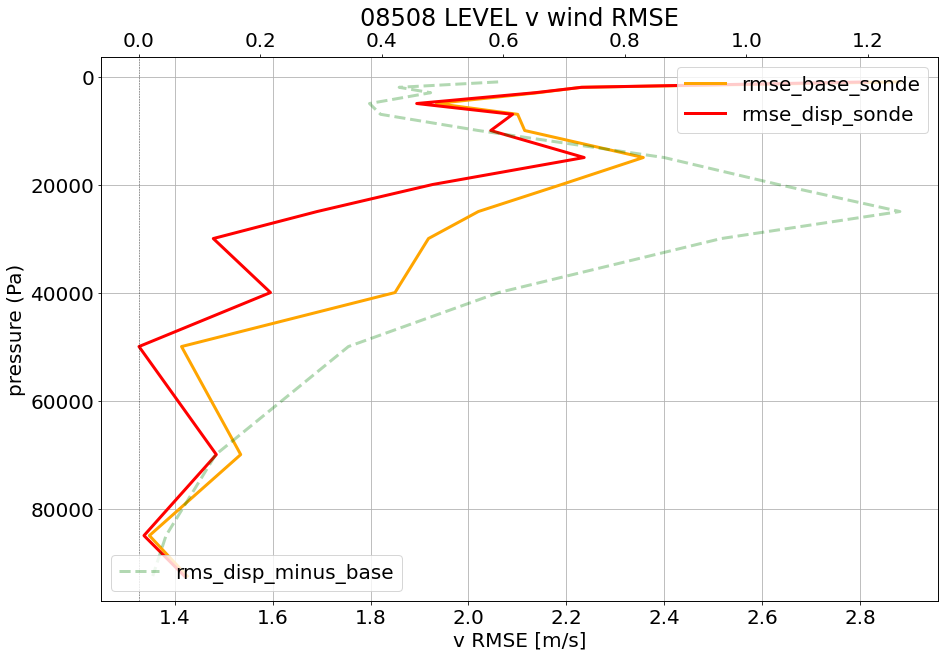

In [14]:
stats = ['08508']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  an
valid ascents:  362



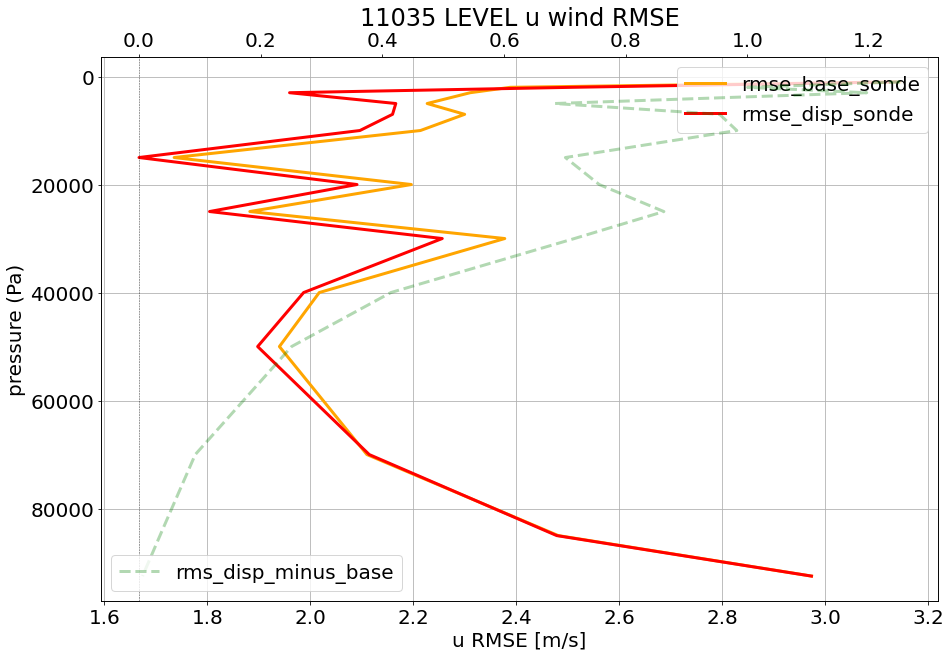

valid ascents:  362



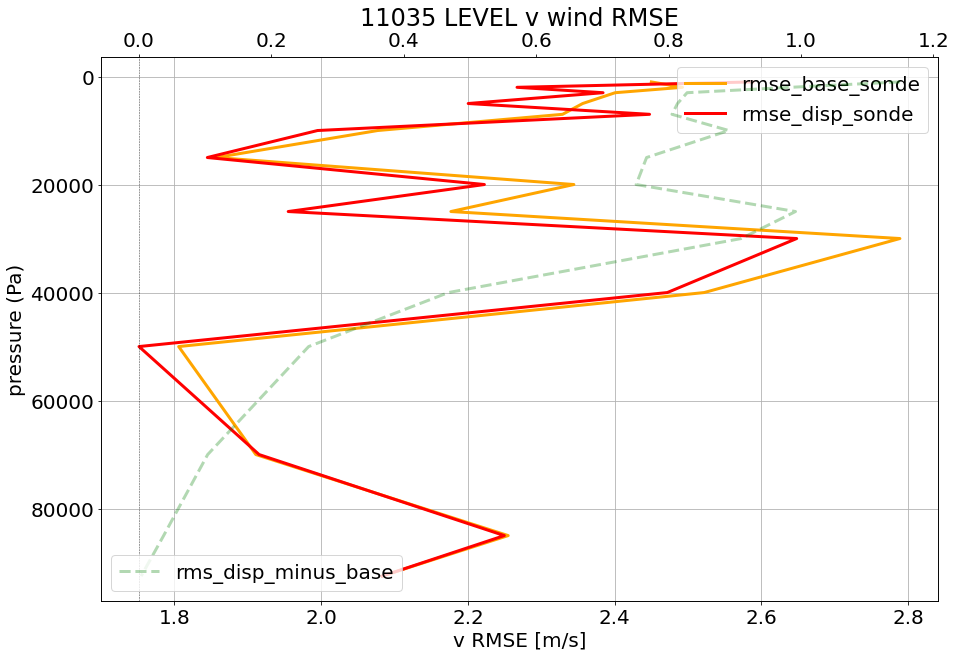

In [15]:
stats = ['11035']
year = 2010
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  an
valid ascents:  362



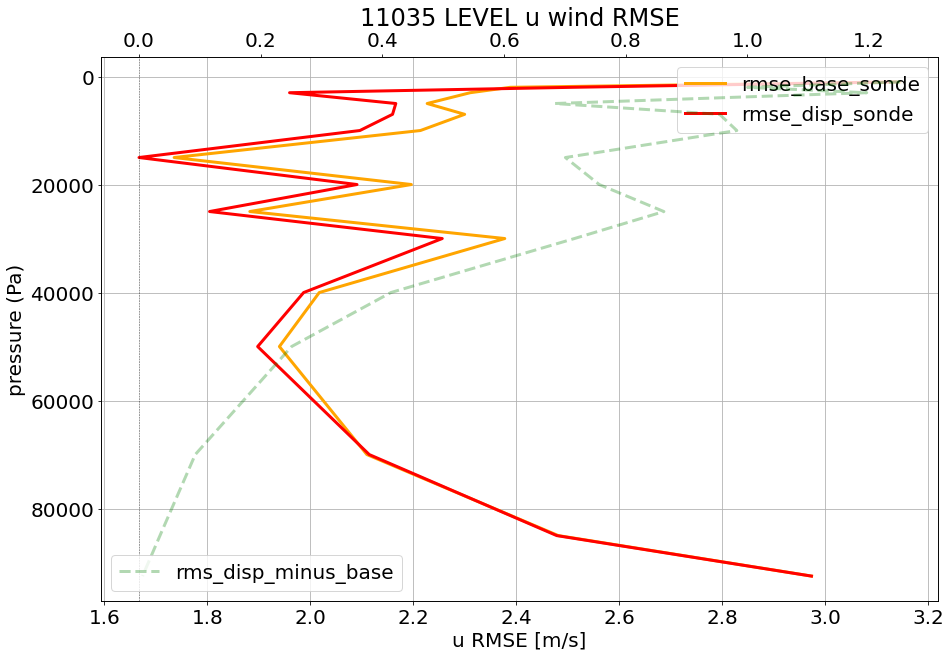

valid ascents:  362



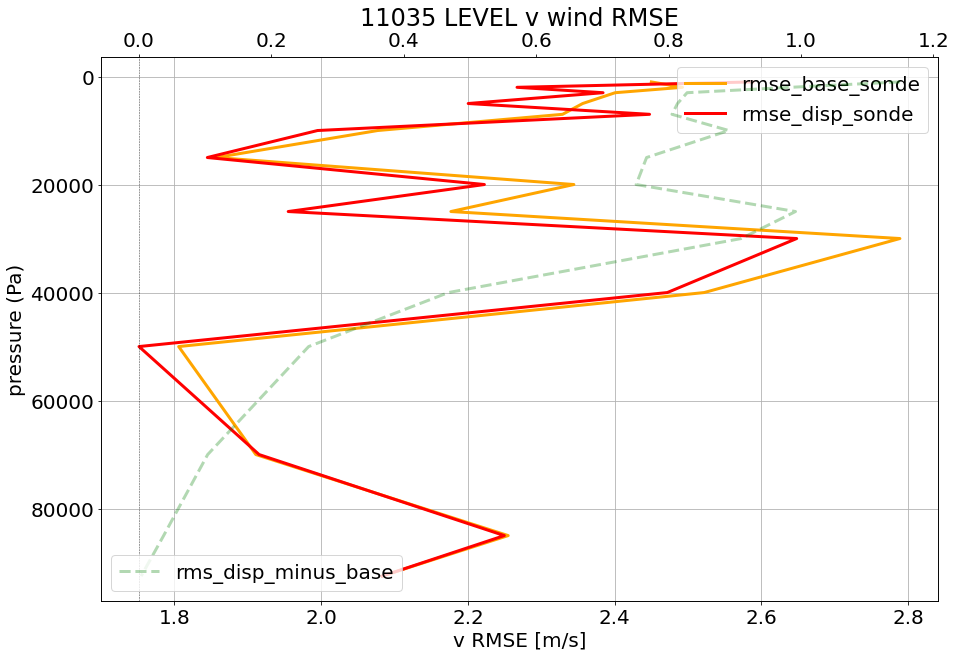

In [16]:
stats = ['11035']
year = 2010
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  an
valid ascents:  355



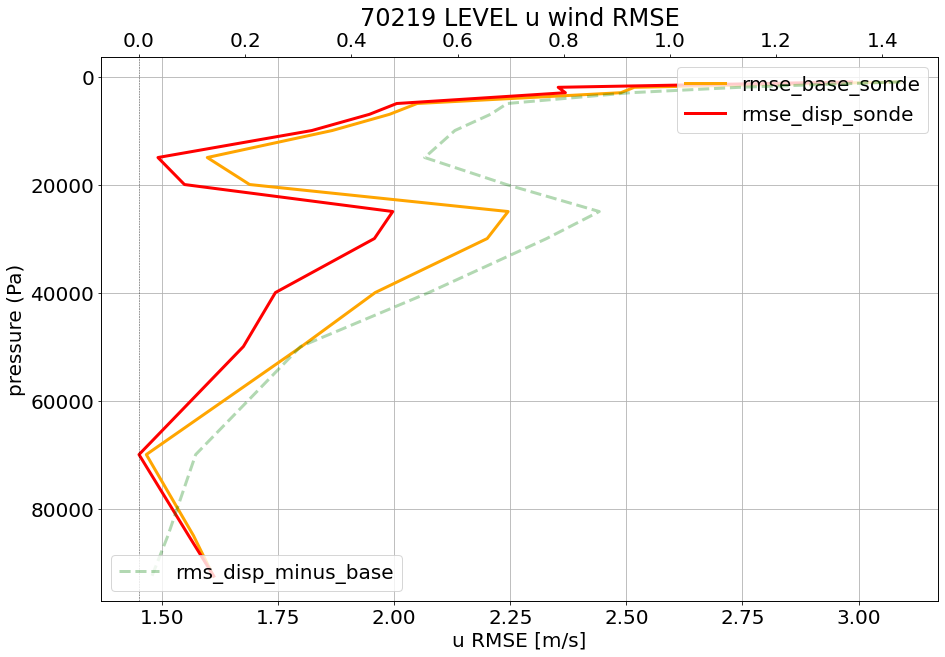

valid ascents:  355



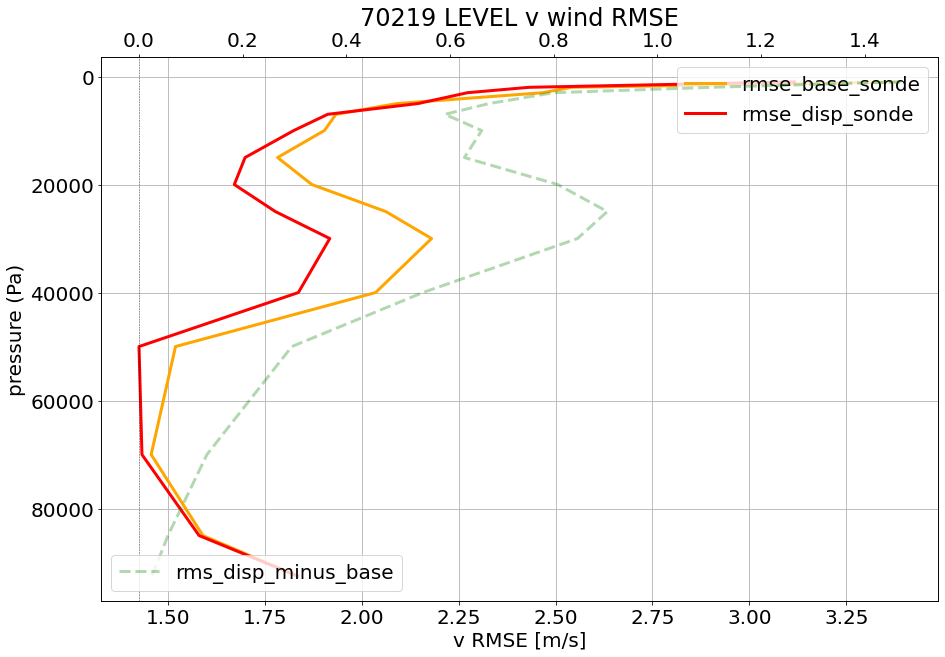

In [17]:
stats = ['70219']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  an
valid ascents:  348



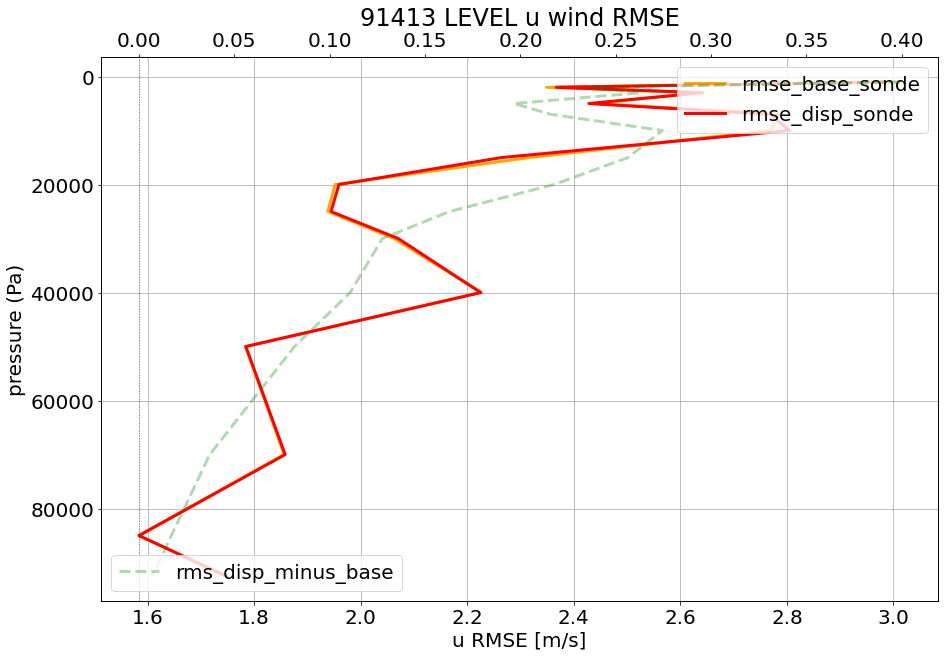

valid ascents:  348



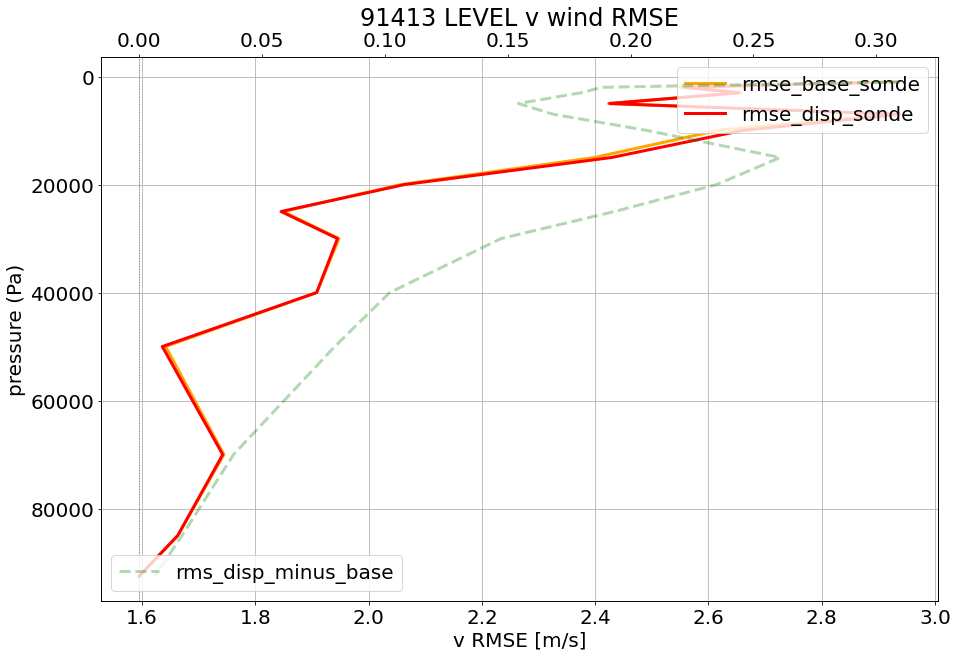

In [18]:
stats = ['91413']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  an
valid ascents:  366



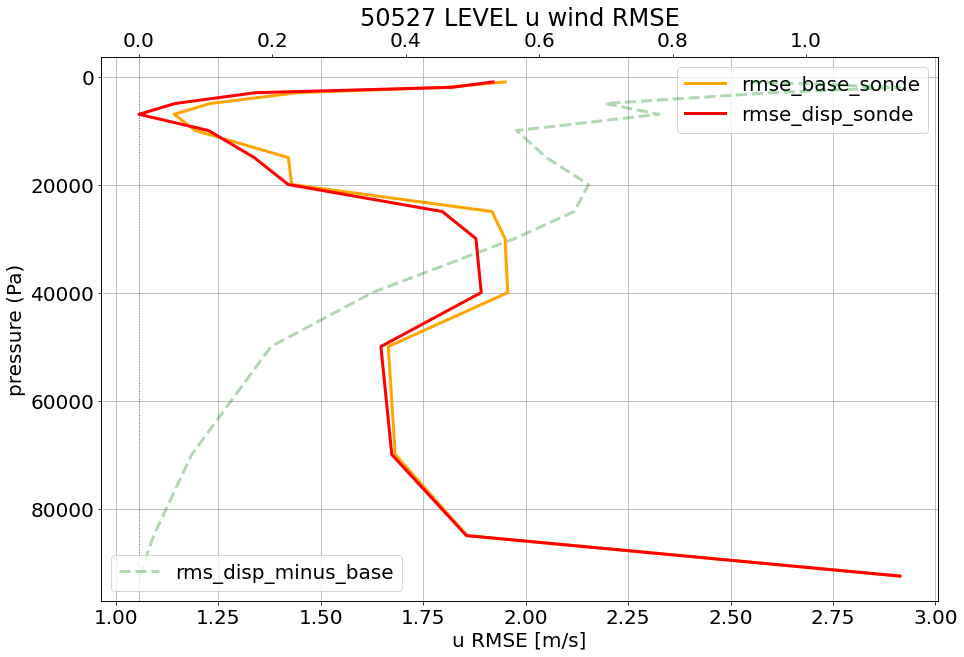

valid ascents:  366



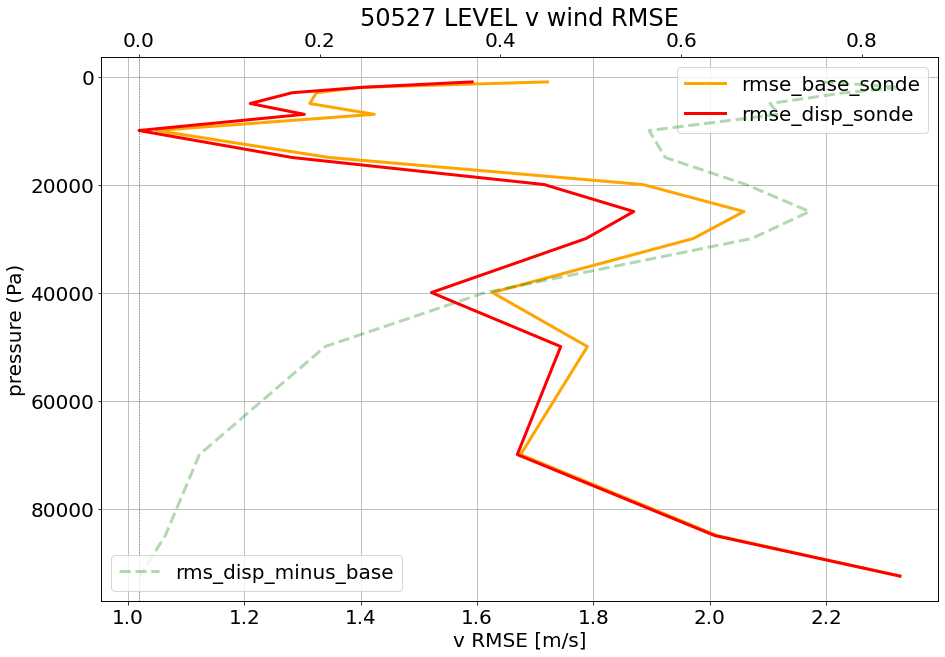

In [19]:
stats = ['50527']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='an')

compare to:  fc
valid ascents:  351



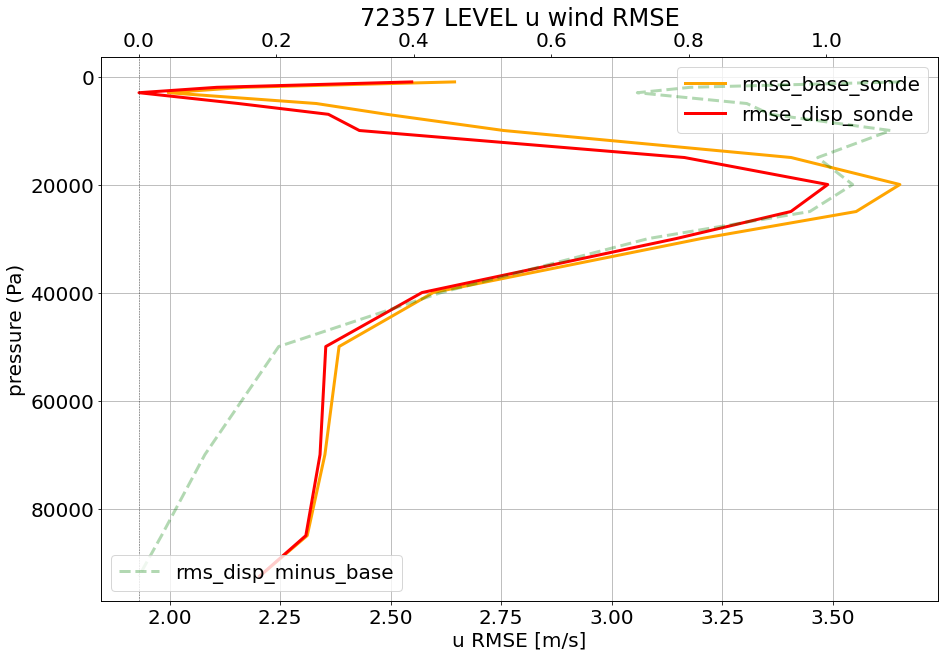

valid ascents:  351



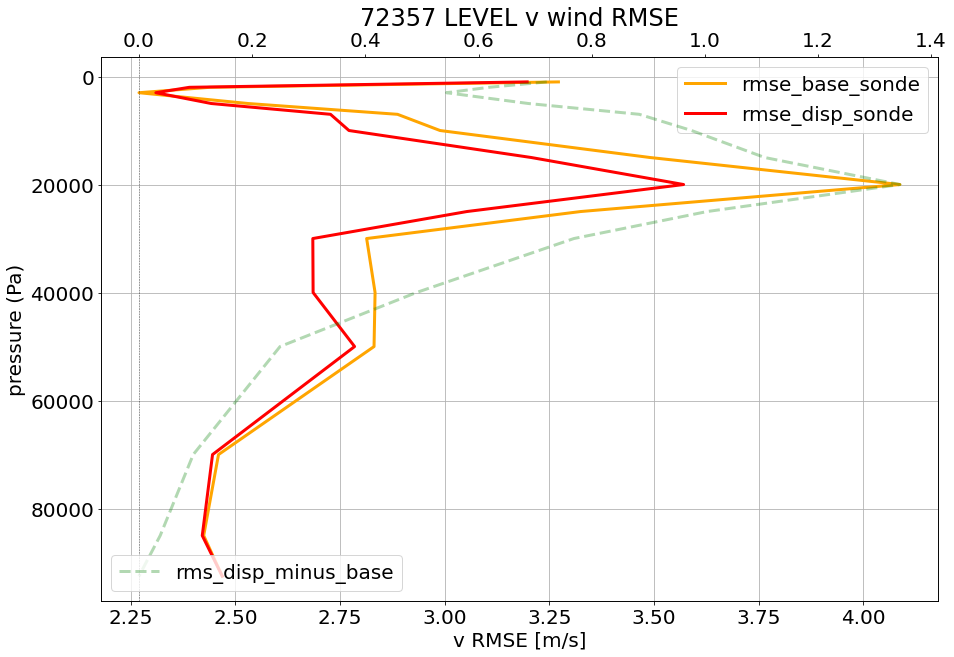

In [20]:
stats = ['72357']
year = 2020
time = [11,12,13]
month = False
trajectory_rmse (stats=stats, year=year, month=month, time=time, show_ascents=False, show_date=False, min_disp=0,compare_to='fc')